In [2]:
import os
import itertools

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import random

from os import listdir
from os.path import isfile, join
import pickle
import time

plt.style.use('seaborn-white')

%matplotlib inline

from scipy.stats import gamma, poisson

import epyestim
import epyestim.covid19 as covid19
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import datetime

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE, r2_score
from xgboost import XGBRegressor, DMatrix, train
from sklearn.multioutput import MultiOutputRegressor

from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
from pykalman import KalmanFilter

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, TimeDistributed, RepeatVector
from keras.callbacks import EarlyStopping

import plotly.express as px
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

from functools import partial
import copy


to_sum_KPIs = ['totale_casi_giornalieri', 'terapia_intensiva_giornalieri', 'terapia_intensiva', 'nuovi_positivi', 'tamponi_giornalieri']
covidKPIsPrecompute = ['%pos']+to_sum_KPIs
trafficKPIsPrecompute = ['Handover', 'Download vol.', 'Upload vol.', '#Users']
covidKPIsToSmoothen = ['R_mean']

# sums regions such as trento + bolzano
def sumRegions(df, dateCol = 'Date', regionCol='Regione', cols = to_sum_KPIs, region1 = "P.A. Bolzano", region2 = "P.A. Trento", regionNew = "Trentino-Alto Adige"):
    dfRegion1, dfRegion2 = df.loc[df[regionCol] == region1], df.loc[df[regionCol] == region2]
    dfRegion1.set_index(dateCol, inplace=True)
    dfRegion2.set_index(dateCol, inplace=True)
    newVals = dfRegion1[to_sum_KPIs]+dfRegion2[to_sum_KPIs]
    newVals.reset_index(inplace=True)
    newVals['Regione'] = regionNew
    df = df.loc[(df[regionCol] != region1) & (df[regionCol] != region2)]
    return df.append(newVals)

# adds italy as cumulative over days
def addItalyData(df, cols):
    dfTemp = df.resample('D', on='Date').sum().reset_index()
    dfTemp['Regione']='Italia'
    dfTemp = dfTemp[cols]
    return pd.concat([df, dfTemp])

def fill_with_areas(dateRange, fig, is_train):
    if is_train:
        color = 'rgba(255, 0, 0, 0.2)'
    else:
        color = 'rgba(0, 0, 255, 0.2)'
    fig.add_shape(type="rect",
        yref="paper",
        x0=dateRange[0], y0=0,
        x1=dateRange[-1], y1=1,
        line=dict(
            width=0,
        ),
        fillcolor=color,
    )
    
    return fig

data_path = "/Users/filipkrasniqi/Documents/Datasets.tmp/traffic-covid/"
by_region_path = "{}By_Region/".format(data_path)
saved = "{}saved/".format(data_path)
traffic_daily = "{}TS_1800_daily.pkl".format(saved)
region_traffic_daily = "{}all.pkl".format(saved)
covid = "{}covid/".format(data_path)
covid_daily = "{}covid_2604.csv".format(covid)

capped_last_date = pd.to_datetime('2021-03-23')

# Preprocessing

## Handle temperature data

### Import

## Handle COVID data

### Import

In [3]:
recompute_rt = True
import_covid  = True
path_covid = "{}covid.csv".format(saved)

if import_covid:
    df_covid = pd.read_csv(covid_daily, delimiter=';')
    if "Regione" not in df_covid.columns:
        df_covid.rename(columns={'denominazione_regione': 'Regione'}, inplace=True)
        df_covid['tamponi_giornalieri'] = df_covid.groupby([
                        'Regione'])['tamponi'].diff()
        df_covid.loc[df_covid['tamponi_giornalieri'].isna() ,
                               'tamponi_giornalieri'] = df_covid['tamponi']


        df_covid['deceduti_giornalieri'] = df_covid.groupby([
                            'Regione'])['deceduti'].diff()
        df_covid.loc[df_covid['deceduti_giornalieri'].isna() ,
                               'deceduti_giornalieri'] = df_covid['deceduti']

        df_covid['terapia_intensiva_giornalieri'] = df_covid.groupby([
                            'Regione'])['terapia_intensiva'].diff()
        df_covid.loc[df_covid['terapia_intensiva_giornalieri'].isna() ,
                               'terapia_intensiva_giornalieri'] = df_covid['terapia_intensiva']

        df_covid['totale_casi_giornalieri'] = df_covid.groupby([
                            'Regione'])['totale_casi'].diff()
        df_covid.loc[df_covid['totale_casi_giornalieri'].isna() ,
                               'totale_casi_giornalieri'] = df_covid['totale_casi']
    covid_cols = ['Date', 'Regione', 'terapia_intensiva', 'nuovi_positivi', 'tamponi_giornalieri', 'totale_casi', 'deceduti', 'totale_casi_giornalieri', 'terapia_intensiva_giornalieri']
    
    try:
        df_covid.data = pd.to_datetime(df_covid.data)
        df_covid.rename(columns={'data': 'Date'}, inplace=True)
    except:
        pass # already correct name
    df_covid = sumRegions(df_covid)
    regions_covid = df_covid['Regione'].unique()
    #df_covid = df_covid[df_covid['Regione'].isin(regions)].dropna()
    df_covid.to_csv(path_covid)
else:
    try:
        del df_covid
    except:
        print("No df covid")
        
regions = df_covid.Regione.unique()

### Compute Rt

In [4]:
dfs = []
path_covid_predictions="{}predictions/covid_ma.pkl".format(saved)
if recompute_rt:
    for r in regions:
        print("REGIONE: {}".format(r))
        current_df = df_covid.loc[df_covid['Regione'] == r]
        current_df['Date'] = pd.to_datetime(current_df['Date']).dt.date
        current_df['DateIndex'] = current_df.loc[:, 'Date']
        current_df.set_index('DateIndex', inplace=True)
        #current_df = current_df.loc[current_df['nuovi_positivi'] > 0]
        current_df = current_df.loc[pd.to_datetime('2020/03/01'):]
        idxs = (current_df['nuovi_positivi'] < 0)# | (current_df.isna()) | (current_df['nuovi_positivi'] == np.inf) | (current_df['nuovi_positivi'] == -np.inf)
        if idxs.sum() > 0:
            current_df.loc[idxs, 'nuovi_positivi'] = np.nan
        current_df.fillna(method='ffill', inplace=True)
        current_df.dropna(subset=['nuovi_positivi'], inplace=True)
        #current_df[current_df.loc[:, 'nuovi_positivi']]
        #current_df.dropna(subset=['nuovi_positivi'], inplace=True)
        #
        current_df = current_df.drop_duplicates(keep='first')
        #print(current_df['nuovi_positivi'].shape, current_df['nuovi_positivi'].apply(lambda x: x < 0).sum())
        #current_df.dropna(subset=['totale_casi_giornalieri'], inplace=True)
        #print(current_df['totale_casi_giornalieri'].isna().sum())
        #print(current_df['totale_casi_giornalieri'].sum())
        r_t_series = covid19.r_covid(current_df['nuovi_positivi'])
        current_df = pd.merge(current_df, r_t_series, left_index=True, right_index=True)
        dfs.append(current_df)
    df_covid_predictions = pd.concat(dfs)
    del dfs
    df_covid_predictions.set_index(['Date', 'Regione'], inplace=True)
    df_covid_predictions['%pos'] = (df_covid_predictions['nuovi_positivi']/df_covid_predictions['tamponi_giornalieri'])
    df_covid_predictions.to_pickle(path_covid_predictions)
else:
    df_covid_predictions = pd.read_pickle(path_covid_predictions)

df_unseen_covid = df_covid_predictions.loc[df_covid_predictions.index.get_level_values('Date')>=capped_last_date]
#df_covid_predictions = df_covid_predictions.loc[df_covid_predictions.index.get_level_values('Date')<capped_last_date]

REGIONE: Abruzzo


<ipython-input-4-3eacff39e26b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_df['Date'] = pd.to_datetime(current_df['Date']).dt.date
<ipython-input-4-3eacff39e26b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_df['DateIndex'] = current_df.loc[:, 'Date']


REGIONE: Basilicata


<ipython-input-4-3eacff39e26b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_df['Date'] = pd.to_datetime(current_df['Date']).dt.date
<ipython-input-4-3eacff39e26b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_df['DateIndex'] = current_df.loc[:, 'Date']


REGIONE: Calabria


<ipython-input-4-3eacff39e26b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_df['Date'] = pd.to_datetime(current_df['Date']).dt.date
<ipython-input-4-3eacff39e26b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_df['DateIndex'] = current_df.loc[:, 'Date']


REGIONE: Campania


<ipython-input-4-3eacff39e26b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_df['Date'] = pd.to_datetime(current_df['Date']).dt.date
<ipython-input-4-3eacff39e26b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_df['DateIndex'] = current_df.loc[:, 'Date']


REGIONE: Emilia-Romagna


<ipython-input-4-3eacff39e26b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_df['Date'] = pd.to_datetime(current_df['Date']).dt.date
<ipython-input-4-3eacff39e26b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_df['DateIndex'] = current_df.loc[:, 'Date']


REGIONE: Friuli Venezia Giulia


<ipython-input-4-3eacff39e26b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_df['Date'] = pd.to_datetime(current_df['Date']).dt.date
<ipython-input-4-3eacff39e26b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_df['DateIndex'] = current_df.loc[:, 'Date']


REGIONE: Lazio


<ipython-input-4-3eacff39e26b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_df['Date'] = pd.to_datetime(current_df['Date']).dt.date
<ipython-input-4-3eacff39e26b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_df['DateIndex'] = current_df.loc[:, 'Date']


REGIONE: Liguria


<ipython-input-4-3eacff39e26b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_df['Date'] = pd.to_datetime(current_df['Date']).dt.date
<ipython-input-4-3eacff39e26b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_df['DateIndex'] = current_df.loc[:, 'Date']


REGIONE: Lombardia


<ipython-input-4-3eacff39e26b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_df['Date'] = pd.to_datetime(current_df['Date']).dt.date
<ipython-input-4-3eacff39e26b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_df['DateIndex'] = current_df.loc[:, 'Date']


REGIONE: Marche


<ipython-input-4-3eacff39e26b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_df['Date'] = pd.to_datetime(current_df['Date']).dt.date
<ipython-input-4-3eacff39e26b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_df['DateIndex'] = current_df.loc[:, 'Date']


REGIONE: Molise


<ipython-input-4-3eacff39e26b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_df['Date'] = pd.to_datetime(current_df['Date']).dt.date
<ipython-input-4-3eacff39e26b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_df['DateIndex'] = current_df.loc[:, 'Date']


REGIONE: Piemonte


<ipython-input-4-3eacff39e26b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_df['Date'] = pd.to_datetime(current_df['Date']).dt.date
<ipython-input-4-3eacff39e26b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_df['DateIndex'] = current_df.loc[:, 'Date']


REGIONE: Puglia


<ipython-input-4-3eacff39e26b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_df['Date'] = pd.to_datetime(current_df['Date']).dt.date
<ipython-input-4-3eacff39e26b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_df['DateIndex'] = current_df.loc[:, 'Date']


REGIONE: Sardegna


<ipython-input-4-3eacff39e26b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_df['Date'] = pd.to_datetime(current_df['Date']).dt.date
<ipython-input-4-3eacff39e26b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_df['DateIndex'] = current_df.loc[:, 'Date']


REGIONE: Sicilia


<ipython-input-4-3eacff39e26b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_df['Date'] = pd.to_datetime(current_df['Date']).dt.date
<ipython-input-4-3eacff39e26b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_df['DateIndex'] = current_df.loc[:, 'Date']


REGIONE: Toscana


<ipython-input-4-3eacff39e26b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_df['Date'] = pd.to_datetime(current_df['Date']).dt.date
<ipython-input-4-3eacff39e26b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_df['DateIndex'] = current_df.loc[:, 'Date']


REGIONE: Umbria


<ipython-input-4-3eacff39e26b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_df['Date'] = pd.to_datetime(current_df['Date']).dt.date
<ipython-input-4-3eacff39e26b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_df['DateIndex'] = current_df.loc[:, 'Date']


REGIONE: Valle d'Aosta


<ipython-input-4-3eacff39e26b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_df['Date'] = pd.to_datetime(current_df['Date']).dt.date
<ipython-input-4-3eacff39e26b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_df['DateIndex'] = current_df.loc[:, 'Date']


REGIONE: Veneto


<ipython-input-4-3eacff39e26b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_df['Date'] = pd.to_datetime(current_df['Date']).dt.date
<ipython-input-4-3eacff39e26b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_df['DateIndex'] = current_df.loc[:, 'Date']


REGIONE: Trentino-Alto Adige


<ipython-input-4-3eacff39e26b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_df['Date'] = pd.to_datetime(current_df['Date']).dt.date
<ipython-input-4-3eacff39e26b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_df['DateIndex'] = current_df.loc[:, 'Date']


In [5]:
df_covid_predictions.loc[df_covid_predictions.index.get_level_values('Regione')=='Lombardia']['R_mean'].to_csv("{}predictions/covid_lombardia.csv".format(saved))

## Handle traffic data

### Import

In [39]:
import_traffic = True
recompute_kalman = False
recompute_MA = True
path_traffic = "{}traffic.csv".format(saved)
start_date_unavailable, end_date_unavailable = pd.to_datetime('2020-08-01'), pd.to_datetime('2020-10-01')
dates_unavailable = pd.date_range(start_date_unavailable, end_date_unavailable)
if import_traffic:
    df_traffic_daily = pd.read_pickle(region_traffic_daily)
    df_traffic_daily.loc[df_traffic_daily['Regione'] == "Emilia Romagna", "Regione"] = "Emilia-Romagna"
    df_traffic_predictions = df_traffic_daily.loc[df_traffic_daily['Regione'].isin(regions)]
    df_traffic_predictions = df_traffic_predictions.groupby('Regione').resample('D', on='Date').sum().reset_index()
    df_traffic_predictions = df_traffic_predictions.replace({'0':np.nan, 0:np.nan})
    df_traffic_predictions = df_traffic_predictions.loc[(df_traffic_predictions['Date']<start_date_unavailable)|(df_traffic_predictions['Date']>=end_date_unavailable)]
    df_traffic_predictions = df_traffic_predictions.fillna(method='ffill')
    df_traffic_predictions['Date'] = pd.to_datetime(df_traffic_predictions['Date']).dt.date
    df_traffic_predictions.set_index(['Date', 'Regione'], inplace=True)
    df_traffic_predictions.to_csv(path_traffic)
else:
    df_traffic_predictions = pd.read_csv(path_traffic)
    df_traffic_predictions['Date'] = pd.to_datetime(df_traffic_predictions['Date']).dt.date
    df_traffic_predictions.set_index(['Date', 'Regione'], inplace=True)

In [40]:
df_traffic_predictions

,,RRC_S_Succ,RRC_S_Att,RRC_S_SR,RRC_RE_Succ,RRC_RE_Att,IntraF_Hout_Succ,IntraF_Hout_Att,InterF_Hout_Succ,InterF_Hout_Att,Handover,Hin_Att,InterR_HO_OUT_E2W_Succ,InterR_HO_OUT_E2W_Att,InterR_HO_OUT_E2G_Succ,InterR_HO_OUT_E2G_Att,Download vol.,Upload vol.,#Users,ERAB_S_Succ,ERAB_S_Att
Date,Regione,,,,,,,,,,,,,,,,,,,,
2020-01-01,Abruzzo,722914109.0,723559625.0,2399.867376,2109077.0,2755617.0,69768501.0,69410898.0,29058705.0,29152448.0,87240956.0,88551230.0,106931.0,109647.0,39290.0,41672.0,2.892451e+15,2.471538e+14,3.184160e+06,NaN,NaN
2020-01-02,Abruzzo,718452155.0,718983916.0,2399.873855,2131711.0,2792486.0,84230949.0,83904966.0,28343453.0,28429081.0,103161979.0,104312783.0,166524.0,171219.0,51450.0,54111.0,2.675922e+15,2.237421e+14,3.220258e+06,NaN,NaN
2020-01-03,Abruzzo,732998734.0,733541088.0,2399.825795,2155915.0,2846211.0,86249305.0,85912857.0,29106383.0,29189094.0,105738844.0,106924551.0,172648.0,177169.0,53143.0,55830.0,2.691140e+15,2.226775e+14,3.271108e+06,NaN,NaN
2020-01-04,Abruzzo,729004305.0,729571151.0,2399.844823,2116294.0,2829792.0,84713582.0,84381441.0,29279339.0,29355363.0,104350340.0,105532420.0,148356.0,152254.0,45396.0,47662.0,2.647715e+15,2.187153e+14,3.189687e+06,NaN,NaN
2020-01-05,Abruzzo,706629792.0,707240933.0,2399.768004,2272802.0,2936730.0,79952197.0,79642735.0,28033160.0,28114250.0,98488811.0,99607902.0,112385.0,115241.0,33569.0,35454.0,2.735595e+15,2.249541e+14,3.108692e+06,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-27,Veneto,189923917.0,189994425.0,2400.000000,359693.0,520478.0,4838341.0,4858073.0,6285441.0,6348633.0,15257980.0,15267670.0,802.0,805.0,10978.0,11446.0,1.394239e+12,1.205965e+11,9.908065e+05,344661713.0,344702032.0
2021-03-28,Veneto,173256302.0,173320143.0,2300.000000,324508.0,466083.0,3732084.0,3748124.0,5020619.0,5074756.0,11304766.0,11312747.0,502.0,503.0,7165.0,7530.0,1.369991e+12,1.094333e+11,9.412702e+05,314772524.0,314808735.0
2021-03-29,Veneto,204258594.0,204333802.0,2400.000000,420166.0,606121.0,6152635.0,6176506.0,7615576.0,7684566.0,20492503.0,20503728.0,587.0,591.0,18029.0,18817.0,1.342536e+12,1.460220e+11,1.096273e+06,371058904.0,371104455.0


### Smoothen with Kalman filter

In [74]:
# apply Kalman Filter to traffic features
dict_kalman = {}
path_traffic_predictions="{}predictions/traffic.pkl".format(saved)
if recompute_kalman:
    for trafficKPI in trafficKPIsPrecompute:
        #current_df_kalman = pd.DataFrame({"{}_smoothened".format(trafficKPI): []})
        dfs_current_kpi = []
        for region in regions:
            kf = KalmanFilter(transition_matrices = [1],
                      observation_matrices = [1],
                      initial_state_mean = 0,
                      initial_state_covariance = 1,
                      observation_covariance=1,
                      transition_covariance=.05)

            series = df_traffic_predictions.xs(region, level=1)[trafficKPI]
            # t = 21/03 -> current_series = series[:t] -> .em(current_series) -> features_for_day_t = smooth(current_series)
            kf = kf.em(series)                                           # 01/03/20 -> 31/01/21
            (smoothened, smoothed_state_covariances) = kf.smooth(series) # 01/03/20 -> 31/01/21
            df_region_kpi = pd.DataFrame({"noisy": series})
            df_region_kpi['smooth'] = smoothened.squeeze()
            df_region_kpi['Regione'] = region
            df_region_kpi.reset_index(inplace=True)
            df_region_kpi.set_index(['Date', 'Regione'], inplace=True)
            dfs_current_kpi.append(df_region_kpi)

            dict_kalman["{}_{}".format(trafficKPI, region)] = kf

        df_traffic_predictions["{}_kf".format(trafficKPI)] = pd.concat(dfs_current_kpi)['smooth']
        df_traffic_predictions.to_pickle(path_traffic_predictions)
else:
    pass
    #df_traffic_predictions = pd.read_pickle(path_traffic_predictions)

In [41]:
# apply MA to traffic features
path_traffic_predictions="{}predictions/traffic.pkl".format(saved)
if recompute_MA:
    for trafficKPI in trafficKPIsPrecompute:
        #current_df_kalman = pd.DataFrame({"{}_smoothened".format(trafficKPI): []})
        dfs_current_kpi = []
        for region in regions:
            series = df_traffic_predictions.xs(region, level=1)[trafficKPI]
            # t = 21/03 -> current_series = series[:t] -> .em(current_series) -> features_for_day_t = smooth(current_series)
            rolling_amount = 7
            series_ma = series.rolling(rolling_amount).mean()
            
            series_ma = series_ma.loc[(series_ma.index<start_date_unavailable)|(series_ma.index>=end_date_unavailable+pd.Timedelta(days=rolling_amount))]
            
            df_region_kpi = pd.DataFrame({"noisy": series})
            df_region_kpi['smooth'] = series_ma
            df_region_kpi['Regione'] = region
            df_region_kpi.reset_index(inplace=True)
            df_region_kpi.set_index(['Date', 'Regione'], inplace=True)
            dfs_current_kpi.append(df_region_kpi)

        df_traffic_predictions["{}_MA".format(trafficKPI)] = pd.concat(dfs_current_kpi)['smooth']
        df_traffic_predictions.to_pickle(path_traffic_predictions)
    for covidKPI in covidKPIsToSmoothen:
        #current_df_kalman = pd.DataFrame({"{}_smoothened".format(trafficKPI): []})
        dfs_current_kpi = []
        for region in regions:
            series = df_covid_predictions.xs(region, level='Regione')[covidKPI]
            # t = 21/03 -> current_series = series[:t] -> .em(current_series) -> features_for_day_t = smooth(current_series)
            rolling_amount = 7
            series_ma = series.rolling(rolling_amount).mean()
            
            #series_ma = series_ma.loc[(series_ma.index<start_date_unavailable)|(series_ma.index>=end_date_unavailable+pd.Timedelta(days=rolling_amount))]
            
            df_region_kpi = pd.DataFrame({"noisy": series})
            df_region_kpi['smooth'] = series_ma
            df_region_kpi['Regione'] = region
            df_region_kpi.reset_index(inplace=True)
            df_region_kpi.set_index(['Date', 'Regione'], inplace=True)
            dfs_current_kpi.append(df_region_kpi)

        df_covid_predictions["{}_MA".format(covidKPI)] = pd.concat(dfs_current_kpi)['smooth']
        df_covid_predictions.to_pickle(path_covid_predictions)
else:
    df_covid_predictions = pd.read_pickle(path_covid_predictions)

<AxesSubplot:xlabel='Date'>

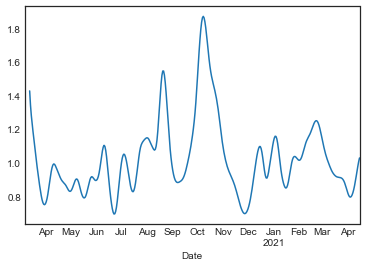

In [42]:
df_covid_predictions.xs('Lombardia', level='Regione')['R_mean_MA'].plot()

# Forecasting

## Define KPIs

In [43]:
# scenario_input: both, only_traffic, only_traffic_no_mobility, only_covid
scenario_input = "both"
is_both, is_only_traffic, is_no_mobility, is_only_covid = \
    scenario_input == 'both', scenario_input == 'only_traffic', \
    scenario_input == 'only_traffic_no_mobility', scenario_input == 'only_covid'
assert is_both or is_only_traffic or is_no_mobility or is_only_covid, "Wrong"
trafficKPIs, covidKPIs = [], []
if is_both:
    trafficKPIs = [col for col in df_traffic_predictions.columns if "MA" in col]
    covidKPIs = [col for col in df_covid_predictions.columns if "mean" in col and "MA" not in col]
elif is_only_traffic:
    trafficKPIs = [col for col in df_traffic_predictions.columns if "MA" in col]
elif is_no_mobility:
    trafficKPIs = [col for col in df_traffic_predictions.columns if "MA" in col and "over" not in col and "sers" not in col]
elif is_only_covid:
    covidKPIs = [col for col in df_covid_predictions.columns if "mean" in col and "MA" not in col]
temperatureKPIs = []#[col for col in df_temperature.columns if "min" in col]
targetCovid = ['R_mean']

In [44]:
trafficKPIs

['Handover_MA', 'Download vol._MA', 'Upload vol._MA', '#Users_MA']

In [45]:
covidKPIs

['R_mean']

In [46]:
def build_df_prediction(range_dates, min_farsightness, farsightness, delta_features, step_target):
    lags = range(delta_features)
    lags_target = range(min_farsightness, farsightness, step_target)
    all_dfs = []
    # prima ondata
    for region in regions_to_train:
        # filter ts by region
        df_traffic_ts = df_traffic_predictions.loc[(df_traffic_predictions.index.get_level_values(1)==region), trafficKPIs].copy()
        df_covid_ts = df_covid_predictions.loc[df_covid_predictions.index.get_level_values(1)==region, list(set(covidKPIs+targetCovid))].copy()
        #df_temperature_ts = df_temperature.loc[df_temperature.index.get_level_values(1)==region, temperatureKPIs].copy()
        
        df_traffic_ts = df_traffic_ts.groupby(level=1).transform(lambda x: (x-x.mean())/x.std(ddof=1))
        #df_temperature_ts = df_temperature_ts.groupby(level=1).transform(lambda x: (x-x.mean())/x.std(ddof=1))

        df_covid_ts.reset_index(inplace=True)
        #df_temperature_ts.reset_index(inplace=True)
        df_traffic_ts.reset_index(inplace=True)

        df_covid_ts = df_covid_ts.set_index('Date')
        #df_temperature_ts = df_temperature_ts.set_index('Date')
        df_traffic_ts = df_traffic_ts.set_index('Date')

        df_ts = pd.DataFrame()
        features = []
        targets = []
        target_col = targetCovid[0]
        df_target_ts = df_covid_ts.copy()

        train_dates_intersection = df_traffic_ts.index.intersection(df_covid_ts.index)

        train_dates = []
        #if len(temperatureKPIs) > 0:
        #    train_dates_intersection = train_dates_intersection.isin(df_temperature_ts.index)
        for date_val in train_dates_intersection:
            if any(date_val in x for x in range_dates):
                train_dates.append(date_val)

        train_dates = pd.to_datetime(train_dates)

        df_covid_ts, df_traffic_ts = df_covid_ts.loc[df_covid_ts.index.isin(train_dates)], df_traffic_ts.loc[df_traffic_ts.index.isin(train_dates)]
        #df_temperature_ts = df_temperature_ts.loc[df_temperature_ts.index.isin(train_dates)]
        for lag in lags_target:
            target = "target_{}".format(lag)
            targets.append(target)
            df_ts[target] = df_target_ts.copy().shift(-1*lag)[target_col]
        
        # use also today feature
        use_today_feature = True
        if use_today_feature:
            if len(trafficKPIs) > 0:
                df_ts[trafficKPIs] = df_traffic_ts[trafficKPIs].copy()
                features += trafficKPIs
            if len(covidKPIs) > 0:
                df_ts[covidKPIs] = df_covid_ts[covidKPIs].copy()
                features += covidKPIs
        
        for lag in lags:
            lag_shift = lag+1
            for col in trafficKPIs:
                feature = "{}_{}".format(col, lag_shift)
                #print(feature, df_traffic_ts.shift(lag_shift).loc[:, col])
                df_ts[feature] = df_traffic_ts.copy().shift(lag_shift).loc[:, col]
                features.append(feature)
            for col in covidKPIs:
                feature = "{}_{}".format(col, lag_shift)
                df_ts[feature] = df_covid_ts.copy().shift(lag_shift)[col]
                features.append(feature)
            for col in temperatureKPIs:
                feature = "{}_{}".format(col, lag_shift)
                df_ts[feature] = df_temperature_ts.copy().shift(lag_shift)[col]
                features.append(feature)

        df_ts = df_ts[targets+features]
        df_ts.dropna(subset=features, inplace=True)
        df_ts['Regione'] = region
        df_ts = df_ts.reset_index().set_index(['Date', 'Regione'])
        all_dfs.append(df_ts.copy())
    return pd.concat(all_dfs), targets, features, lags, lags_target

In [47]:
divider_po, divider_so = pd.to_datetime('2020-07-01'), pd.to_datetime('2020-10-01')
start_train_po, end_train_so = pd.to_datetime('2020-03-01'), pd.to_datetime('2020-10-25')
start_po = start_train_po
ranges_train_PO = [pd.date_range(start_po, divider_po)]
ranges_train_SO = [pd.date_range(divider_so, end_train_so)]
last_date_with_unseen = min(df_traffic_predictions.index.get_level_values(0).max(), df_unseen_covid.index.get_level_values(0).max())

last_date = min(last_date_with_unseen, capped_last_date)

ranges_unseen = [pd.date_range(last_date, last_date_with_unseen)]

ranges_so = [pd.date_range(divider_so, last_date)]
regions_to_train = ["Lombardia", "Campania", "Puglia", "Lazio", "Sardegna", "Veneto"]#regions

min_farsightness = 1
farsightness = 35
delta_features = 21
step_target = 1

ranges_test_SO = [pd.date_range(end_train_so-pd.Timedelta(days=delta_features), last_date_with_unseen)]

(df_train_prediction_PO, targets, features, lags, lags_target), (df_train_prediction_SO, _, _, _, _) = \
    build_df_prediction(ranges_train_PO, min_farsightness, farsightness, delta_features, step_target), \
    build_df_prediction(ranges_train_SO, min_farsightness, farsightness, delta_features, step_target)

(df_test_prediction, _, _, _, _) = build_df_prediction(ranges_test_SO, min_farsightness, farsightness, delta_features, step_target)
df_train_prediction = pd.concat([df_train_prediction_PO, df_train_prediction_SO])

df_unseen_prediction = df_test_prediction.loc[df_test_prediction.index.get_level_values('Date')>capped_last_date]
df_test_prediction = df_test_prediction.loc[df_test_prediction.index.get_level_values('Date')<=capped_last_date]

In [48]:
df_train_prediction.to_csv("{}predictions/train.csv".format(saved))

In [51]:
df_train_prediction

,,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target_8,target_9,target_10,target_11,target_12,target_13,target_14,target_15,target_16,target_17,target_18,target_19,target_20,target_21,target_22,target_23,target_24,target_25,target_26,target_27,target_28,target_29,target_30,target_31,target_32,target_33,target_34,Handover_MA,Download vol._MA,Upload vol._MA,#Users_MA,R_mean,Handover_MA_1,Download vol._MA_1,Upload vol._MA_1,#Users_MA_1,R_mean_1,Handover_MA_2,Download vol._MA_2,Upload vol._MA_2,#Users_MA_2,R_mean_2,Handover_MA_3,Download vol._MA_3,Upload vol._MA_3,#Users_MA_3,R_mean_3,Handover_MA_4,Download vol._MA_4,Upload vol._MA_4,#Users_MA_4,R_mean_4,Handover_MA_5,Download vol._MA_5,Upload vol._MA_5,#Users_MA_5,R_mean_5,Handover_MA_6,Download vol._MA_6,Upload vol._MA_6,#Users_MA_6,R_mean_6,Handover_MA_7,Download vol._MA_7,Upload vol._MA_7,#Users_MA_7,R_mean_7,Handover_MA_8,Download vol._MA_8,Upload vol._MA_8,#Users_MA_8,R_mean_8,Handover_MA_9,Download vol._MA_9,Upload vol._MA_9,#Users_MA_9,R_mean_9,Handover_MA_10,Download vol._MA_10,Upload vol._MA_10,#Users_MA_10,R_mean_10,Handover_MA_11,Download vol._MA_11,Upload vol._MA_11,#Users_MA_11,R_mean_11,Handover_MA_12,Download vol._MA_12,Upload vol._MA_12,#Users_MA_12,R_mean_12,Handover_MA_13,Download vol._MA_13,Upload vol._MA_13,#Users_MA_13,R_mean_13,Handover_MA_14,Download vol._MA_14,Upload vol._MA_14,#Users_MA_14,R_mean_14,Handover_MA_15,Download vol._MA_15,Upload vol._MA_15,#Users_MA_15,R_mean_15,Handover_MA_16,Download vol._MA_16,Upload vol._MA_16,#Users_MA_16,R_mean_16,Handover_MA_17,Download vol._MA_17,Upload vol._MA_17,#Users_MA_17,R_mean_17,Handover_MA_18,Download vol._MA_18,Upload vol._MA_18,#Users_MA_18,R_mean_18,Handover_MA_19,Download vol._MA_19,Upload vol._MA_19,#Users_MA_19,R_mean_19,Handover_MA_20,Download vol._MA_20,Upload vol._MA_20,#Users_MA_20,R_mean_20,Handover_MA_21,Download vol._MA_21,Upload vol._MA_21,#Users_MA_21,R_mean_21
Date,Regione,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-27,Lombardia,0.746899,0.759293,0.773715,0.793549,0.824409,0.867998,0.920780,0.970053,1.004197,1.015757,1.010883,0.996203,0.981291,0.969267,0.960391,0.951375,0.939422,0.924769,0.908933,0.893542,0.883420,0.880305,0.881920,0.882002,0.878999,0.870593,0.857344,0.842860,0.828449,0.818670,0.814930,0.820348,0.832584,0.848260,-1.835707,1.031963,1.876010,0.534455,0.736625,-1.786430,0.990955,1.850848,0.546305,0.733165,-1.727969,0.885727,1.825398,0.563326,0.740529,-1.677518,0.749655,1.745469,0.565937,0.760957,-1.629734,0.754191,1.707487,0.572457,0.791645,-1.568933,0.782410,1.682446,0.581171,0.829503,-1.543670,0.829849,1.641004,0.573115,0.868465,-1.538378,0.936862,1.567884,0.554368,0.905320,-1.479834,1.014839,1.490457,0.564300,0.938656,-1.409406,1.115567,1.378413,0.578842,0.969595,-1.274304,1.172011,1.249201,0.616821,1.004967,-1.123254,1.041853,1.014373,0.640378,1.047617,-0.974755,0.786995,0.669660,0.626164,1.097418,-0.742998,0.574186,0.375128,0.650221,1.149560,-0.410363,0.245002,0.051544,0.666189,1.198602,-0.112517,-0.043238,-0.293947,0.670716,1.239912,0.141916,-0.272864,-0.594969,0.677091,1.273147,0.366516,-0.450346,-0.821509,0.684012,1.307763,0.541567,-0.533659,-0.985939,0.680341,1.359452,0.654657,-0.491871,-1.063814,0.690001,1.442958,0.652015,-0.481708,-1.123380,0.639394,1.580230,0.612775,-0.436235,-1.143112,0.619431,1.791521
2020-03-28,Lombardia,0.759293,0.773715,0.793549,0.824409,0.867998,0.920780,0.970053,1.004197,1.015757,1.010883,0.996203,0.981291,0.969267,0.960391,0.951375,0.939422,0.924769,0.908933,0.893542,0.883420,0.880305,0.881920,0.882002,0.878999,0.870593,0.857344,0.842860,0.828449,0.818670,0.814930,0.820348,0.832584,0.848260,0.866021,-1.853354,0.977941,1.877361,0.523060,0.746899,-1.835707,1.031963,1.876010,0.534455,0.736625,-1.786430,0.990955,1.850848,0.546305,0.733165,-1.727969,0.885727,1.825398,0.563326,0.740529,-1.677518,0.749655,1.745469,0.565937,0.7

In [49]:
df_test_prediction.to_csv("{}predictions/test.csv".format(saved))

In [50]:
df_test_prediction.index.get_level_values('Date').max(), df_unseen_prediction.index.get_level_values('Date').min()

(Timestamp('2021-03-23 00:00:00'), Timestamp('2021-03-24 00:00:00'))

In [166]:
params = {'objective': 'reg:squarederror'}

is_xgb = False
is_polynomial = False
is_lstm = True

features_without_lag = trafficKPIs+covidKPIs+temperatureKPIs
num_features_t = len(features_without_lag)
n_timesteps = len(lags)+1

def build_mlp(n_timesteps, n_features):
    model = Sequential()
    model.add(LSTM(128, input_shape=(n_timesteps, n_features)))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    return model

def build_lstm_1(n_timesteps, n_features):
    model = Sequential()
    model.add(LSTM(128, input_shape=(n_timesteps, n_features)))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    return model

def build_lstm_2(n_timesteps, n_features):
    model = Sequential()
    model.add(LSTM(128, input_shape=(n_timesteps, n_features)))
    model.add(Dense(32))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    return model

def build_lstm_3(n_timesteps, n_features):
    model = Sequential()
    model.add(LSTM(128, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(RepeatVector(1))
    model.add(LSTM(64, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    return model

def build_lstm_4(n_timesteps, n_features, n_outputs):
    model = Sequential()
    model.add(LSTM(128, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(64, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    return model

models_constructors = {
    "Poly1": partial(make_pipeline, PolynomialFeatures(1), Ridge()),
    "Poly2": partial(make_pipeline, PolynomialFeatures(2), Ridge()),
    "Poly3": partial(make_pipeline, PolynomialFeatures(3), Ridge()),
    #"RandomForest": RandomForestRegressor,
    "XGBoost": XGBRegressor,
    #"EncDecLSTM": partial(build_lstm_3, n_timesteps, num_features_t)
}

def build_model(model_name):
    is_xgb, is_poly3, is_poly2, is_rf, is_lstm = model_name=="XGBoost", model_name=="Poly3", model_name=="Poly2", model_name=="RandomForest", model_name=="EncDecLSTM"

    if is_poly2:
        return make_pipeline(PolynomialFeatures(2), Ridge())
    elif is_poly3:
        return make_pipeline(PolynomialFeatures(3), Ridge())
    elif is_rf:
        return RandomForestRegressor()
    elif is_xgb:
        return XGBRegressor()
    elif is_lstm:
        return build_lstm_3(n_timesteps, num_features_t)
    else:
        return make_pipeline(PolynomialFeatures(1), Ridge())


training_time = {m: {r:{} for r in regions_to_train} for m in models_constructors.keys()}  

def train_in_interval(interval):
    models_regions = {m: {r:{} for r in regions_to_train} for m in models_constructors.keys()}
    
    # start training
    for region in regions_to_train:
        df_ts = df_train_prediction.loc[df_train_prediction.index.get_level_values(1)==region]
        df_ts = df_ts.reset_index().set_index('Date').drop(columns='Regione')
        df_ts = df_ts.loc[(df_ts.index>=interval[0])&(df_ts.index < interval[1])]
        for model_name in models_constructors.keys():
            for lag in lags_target:
                start_training_time = time.perf_counter()
                target = "target_{}".format(lag)
                df_ts_lag = df_ts.copy().drop(columns=[col for col in targets if (col not in features) and (col != target)]).dropna()
                #print("{} for {} with lag {}: {} -> {}".format(model_name, region, lag, min(interval), max(interval)))
                is_lstm = "lstm" in model_name.lower()
                model = build_model(model_name)
                if is_lstm:
                    callback = EarlyStopping(monitor='loss', patience=3)
                    # N x T x F
                    lstm_input = df_ts_lag[features].to_numpy().reshape(-1, n_timesteps, num_features_t, order='C')
                    model.fit(lstm_input, df_ts_lag[target], epochs=100, batch_size=32, verbose=0, callbacks=[callback])
                    models_regions[model_name][region][lag] = model
                else:
                    model.fit(df_ts_lag[features].values, df_ts_lag[target])
                    models_regions[model_name][region][lag] = model
                new_time = time.perf_counter()
                training_time[model_name][region][lag] = new_time - start_training_time
    return models_regions

In [167]:
do_train = True

if do_train:
    models_regions = train_in_interval((start_train_po, end_train_so))

In [1]:
train_dates_region_every_n = {}
test_dates_region_every_n = {}
train_dates_region = {}
test_dates_region = {}
df_ts_test_region = {}

wfval_time = {m: {r:{} for r in regions_to_train} for m in models_constructors.keys()}

def test_in_interval(interval):
    #print("TEST START")
                
    df_results = pd.DataFrame() # lag, region, prediction, target; index = date
    results_dict = []

    for region in regions_to_train:
        df_ts = df_test_prediction.loc[df_test_prediction.index.get_level_values(1)==region]
        df_ts = df_ts.reset_index().set_index('Date').drop(columns='Regione')
        df_ts = df_ts.loc[(df_ts.index>=interval[0])&(df_ts.index < interval[1])]
        first_date, last_date = df_ts.index.min(), df_ts.index.max()
        current_region_values = []
        
        test_dates_region[region] = pd.date_range(first_date, last_date)
        df_ts_test_region[region] = df_ts
        test_dates = test_dates_region[region].unique()
        assert test_dates_region[region].shape[0]==len(test_dates), "Something wrong"
        for model_name in models_constructors.keys():
            for idx_lag, lag in enumerate(lags_target):
                start_wfval_time = time.perf_counter()
                target_col = targets[idx_lag]
                #walk_forward_df = df_train_prediction.copy().drop(columns=[col for col in targets if (col not in features) and (col != target_col)]).dropna()
                
                current_df_train_prediction = df_train_prediction.copy().xs(region, level='Regione')
                walk_forward_df = current_df_train_prediction.drop(columns=[col for col in targets if (col not in features) and (col != target_col)]).dropna()
            
                current_df_ts = df_ts[features+[target_col]].copy().dropna()
                test_dates = current_df_ts.index
                print("{} for {} with lag = {}: {} -> {}, {}".format(model_name, region, lag, min(test_dates), max(test_dates), current_df_ts.shape))
                for i, t in enumerate(test_dates):
                    current_df_ts = df_ts.loc[t:t+datetime.timedelta(days=0)]
                    X_test_ts = current_df_ts[features]
                    
                    is_lstm = "lstm" in model_name.lower()
                    
                    if is_lstm:
                        lstm_input = X_test_ts.to_numpy().reshape(-1, n_timesteps, num_features_t, order='C')
                        predictions = models_regions[model_name][region][lag].predict(lstm_input).flatten()
                    else:
                        predictions = models_regions[model_name][region][lag].predict(X_test_ts.values)

                    X_test_fit, y_test_fit = X_test_ts, current_df_ts[target_col].values

                    #current_result = {"date": t + datetime.timedelta(days=lag), "lag": lag, "region": region, "prediction": predictions[0], "target": y_test_fit}
                    current_result = {"model": model_name,"date": t + datetime.timedelta(days=lag), "lag": lag, "region": region, "prediction": predictions[0], "target": y_test_fit[0]}
                    results_dict.append(current_result)

                    walk_forward_df = walk_forward_df.append(current_df_ts)
                    walk_forward_df = walk_forward_df.sort_index()
                    window_train = 45
                    
                    if is_lstm:
                        callback = EarlyStopping(monitor='loss', patience=3)
                        window_train = 32
                        # I keep the last model and update weights using a window (last 30 values)
                        model = models_regions[model_name][region][lag]
                        lstm_input = walk_forward_df[features].to_numpy().reshape(-1, n_timesteps, num_features_t, order='C')
                        lstm_input = lstm_input[-1*window_train:]
                        lstm_target = walk_forward_df[target_col].values[-1*window_train:]
                        model.fit(lstm_input, lstm_target, epochs=10, batch_size=8, verbose=0, callbacks=[callback])
                        models_regions[model_name][region][lag] = model
                    else:
                        use_window = True
                        if use_window:
                            window_walk_forward_df = walk_forward_df.iloc[-1*window_train:]
                            features_vals, targets_vals = window_walk_forward_df[features], window_walk_forward_df[target_col]
                            #features_vals, targets_vals = walk_forward_df[features].iloc[-1*window_train:], walk_forward_df[target_col].iloc[-1*window_train:]
                            #print(features_vals.shape, targets_vals.shape)
                            models_regions[model_name][region][lag] = build_model(model_name)
                            models_regions[model_name][region][lag].fit(features_vals.values, targets_vals)
                        else:
                            # here I should do the same as before, for now not trying because I suppose it's better (to more enphasize recent behaviour)
                            pass
                new_time = time.perf_counter()
                wfval_time[model_name][region][lag] = new_time - start_wfval_time
    df_results = pd.DataFrame(results_dict)
    df_results = df_results.dropna()
    df_results.set_index(['model', 'date', 'region', 'lag'], inplace=True)
    df_results['error']=(df_results['prediction']-df_results['target']).abs()
    df_results['error_2'] = df_results['error']**2
    return models_regions, df_results

min_date, max_date = df_test_prediction.index.get_level_values(0).min(), df_test_prediction.index.get_level_values(0).max()
if do_train:
    models_regions, df_results = test_in_interval((min_date, max_date))
else:
    path_results = "{}predictions/results_v3.csv".format(saved)
    df_results = pd.read_csv(path_results)
    df_results['date'] = pd.to_datetime(df_results['date'])
    df_results.set_index(['model', 'date', 'region', 'lag'], inplace=True)

NameError: name 'models_constructors' is not defined

In [169]:
df_results

prediction    target     error   error_2
model   date       region    lag                                          
Poly1   2020-10-30 Lombardia 1      0.900220  1.060701  0.160481  0.025754
        2020-10-31 Lombardia 1      0.996333  1.035190  0.038857  0.001510
        2020-11-01 Lombardia 1      0.986205  1.009310  0.023105  0.000534
        2020-11-02 Lombardia 1      0.973615  0.985876  0.012261  0.000150
        2020-11-03 Lombardia 1      0.964463  0.968252  0.003789  0.000014
...                                      ...       ...       ...       ...
XGBoost 2021-02-13 Veneto    34     1.166980  1.191350  0.024371  0.000594
        2021-02-14 Veneto    34     1.132433  1.208873  0.076440  0.005843
        2021-02-15 Veneto    34     1.140391  1.228522  0.088132  0.007767
        2021-02-16 Veneto    34     1.210197  1.251320  0.041122  0.001691
        2021-02-17 Veneto    34     1.192842  1.268021  0.075179  0.005652

[63648 rows x 4 columns]

In [170]:
def build_df_results_groupped(df_results, col_prediction = 'prediction', col_error = 'error_2', col_rmse = 'rmse', col_r2 = 'r2', col_mape = 'mape'):
    try:
        groupped_df = df_results.groupby(level=['model', 'region', 'lag'])
    except:
        print("WARNING: not groupped")
        groupped_df = df_results
    df = pd.DataFrame()
    df[col_rmse] = np.sqrt(groupped_df[col_error].mean())
    df[col_r2]=groupped_df.apply(lambda g: r2_score( g[col_prediction], g['target'] ))
    df[col_mape] = groupped_df.apply(lambda g: np.mean(np.abs((g['target'] - g['prediction']) / g['target'])) * 100)
    return df[[col_rmse, col_r2, col_mape]]

df_results_mean = build_df_results_groupped(df_results)

In [171]:
name_current_save = 'results_v1_{}_{}'.format(delta_features, scenario_input)
# Tf = 1-days. Only both. OK
# Tf = 7-days. Only both. OK
# Tf = 14-days. Can be both, only_traffic, only_traffic_no_mobility, only_covid. OK
# Tf = 21-days. Only both. OK
path_results_to_save = "{}predictions/{}".format(saved, name_current_save)
path_results_to_save_models = "{}models/{}".format(saved, name_current_save)
path_results_to_mean_save = "{}_mean".format(path_results_to_save)
path_results_to_model_save = "{}_models".format(path_results_to_save_models)
path_results_to_save_train = "{}_df_train".format(path_results_to_save)
path_results_to_save_test = "{}_df_test".format(path_results_to_save)
path_results_to_save_unseen = "{}_df_unseen".format(path_results_to_save)
path_results_to_time_save = "{}_time".format(path_results_to_save)
print("Saving results...")
df_results.to_csv("{}.csv".format(path_results_to_save))
print("Saving RMSE, R2, MAPE...")
df_results_mean.to_csv("{}.csv".format(path_results_to_mean_save))
print("Saving time of execution...")
#df_results_mean.to_csv("{}.csv".format(path_results_to_mean_save))

with open("{}_train".format(path_results_to_time_save), 'wb') as handle:
    pickle.dump(training_time, handle)
    
with open("{}_wfval".format(path_results_to_time_save), 'wb') as handle:
    pickle.dump(wfval_time, handle)
    
    
print("Saving models...")
for model_name in models_regions.keys():
    for region_name in models_regions[model_name].keys():
        for lag in models_regions[model_name][region_name].keys():
            current_models_dir = '{}/{}/{}/'.format(path_results_to_model_save, model_name, region_name)
            model_path = '{}lag_{}.pkl'.format(current_models_dir, lag)
            try:
                os.makedirs(current_models_dir)
            except:
                pass
            current_model = models_regions[model_name][region_name][lag]
            if "LSTM" in model_name:
                try:
                    os.makedirs(current_models_dir)
                except:
                    pass
                current_model.save("{}lag_{}".format(current_models_dir, lag))
            else:
                with open(model_path, 'wb') as handle:
                    pickle.dump(current_model, handle, protocol=pickle.HIGHEST_PROTOCOL)
# TODO salvare i dataset train, test, unseen
print("Saving datasets...")
df_train_prediction.to_csv("{}.csv".format(path_results_to_save_train))
df_test_prediction.to_csv("{}.csv".format(path_results_to_save_test))
df_unseen_prediction.to_csv("{}.csv".format(path_results_to_save_unseen))

print("OK!")

Saving results...
Saving RMSE, R2, MAPE...
Saving time of execution...
Saving models...
Saving datasets...
OK!


In [172]:
to_check = name_current_save
model_dir = name_current_save+"_models"#'results_v16_ma_poly_after_update_only_covid_models'


path_datasets = "{}predictions/{}".format(saved, to_check)
#path_train = "{}_df_train".format(path_datasets)
path_test = "{}_df_test.csv".format(path_datasets)
path_unseen = "{}_df_unseen.csv".format(path_datasets)

df_test_selected = pd.read_csv(path_test)
# TODO altro??
df_unseen_selected = pd.read_csv(path_unseen)



def init_models_dict(model_dir):
    path_results_dir = join(saved, 'models', model_dir)
    models = os.listdir(path_results_dir)
    models_dict = {}
    for model in models:
        models_dict[model] = {}
        model_path = join(path_results_dir, model)
        regions = os.listdir(model_path)
        for region in regions:
            models_dict[model][region]={}
            region_path = join(model_path, region)
            model_names = sorted([f for f in os.listdir(region_path) if isfile(join(region_path, f))], key=lambda f: int(f.split("_")[1].split(".")[0]))
            for model_name in model_names:
                n_lag = int(model_name.split("_")[1].split(".")[0])
                loaded_model = pickle.load(open(join(region_path, model_name), "rb" ))
                models_dict[model][region][n_lag]=loaded_model
    return models_dict

# reusing same model for prediction
# TODO usare dash per mostrare i 3 casi separati
region='Piemonte'
model_name = 'XGBoost'
is_xgb, is_poly3, is_poly2, is_rf, is_lstm = model_name=="XGBoost", model_name=="Poly3", model_name=="Poly2", model_name=="RandomForest", model_name=="EncDecLSTM"

current_models_regions = init_models_dict(model_dir)
model_per_target = current_models_regions[model_name][region]

farsightness = max(model_per_target.keys())

num_samples_retrain = 120
if is_xgb or is_rf:
    num_samples_retrain = 120
elif is_lstm:
    num_samples_retrain = 80
    
last_date_seen = df_test_selected.index.get_level_values('Date').max()
start_date_unseen = df_test_selected+datetime.timedelta(days=1)

current_region_df = df_unseen_selected.xs(region, level='Regione')
current_region_test_df = df_test_selected.xs(region, level='Regione')

current_train, current_unseen = current_region_test_df, current_region_df

# take only last num_samples_retrain
current_train = current_train.iloc[-num_samples_retrain:]

features_train = current_train[features_selected]
target_series_train = {int(col.split("_")[1]):current_train[col] for col in current_train.columns if "target" in col}
features_unseen = current_unseen[features_selected]
#target_series_unseen = {int(col.split("_")[0]):current_unseen[col] for col in current_unseen.columns if "target" in col}

num_features_t = len([col for col in features_selected if not any(char.isdigit() for char in col)])
n_timesteps = features_train.shape[1]//num_features_t


dates = features_unseen.index
num_dates= len(dates)
predictions, index_predictions = [], []
idx_dates = list(range(0, num_dates, farsightness))
dates_to_return = dates[idx_dates]

fig = go.Figure()

steps_ahead = [f for f in model_per_target.keys() if f <= farsightness]

n_timesteps = 8
num_features_t = len(trafficKPIs)+len(covidKPIs)

min_y, max_y = float("+inf"), float("-inf")

for idx, idx_d in enumerate(idx_dates):
    d = dates[idx_d]
    feature_current = features_unseen.loc[d:d]#.to_numpy()
    #print(feature_current)
    if 'LSTM' in model_name:
        feature_current = feature_current.to_numpy().reshape(-1, n_timesteps, num_features_t, order='C')
    #print(feature_current.index)
    for step_ahead in steps_ahead:
        current_model = model_per_target[step_ahead]
        #print(feature_current.shape)
        current_prediction = current_model.predict(feature_current.values)
        #print(step_ahead)
        if 'LSTM' in model_name:
            try:
                current_prediction = current_prediction[-1][-1][-1]
            except:
                current_prediction = current_prediction[-1][-1]
            predictions.append(current_prediction)
        else:
            current_prediction = current_prediction[-1]
            predictions.append(current_prediction)
        #print("{}: {}".format(step_ahead, current_prediction))
        index_predictions.append(d + datetime.timedelta(days=step_ahead))
    # TODO retrain!!! Simulate that
    if idx < len(idx_dates)-1:
        print("RETRAIN!!!")
        # I can retrain
        next_d = d+datetime.timedelta(days=steps_ahead[-1])
        current_train_df = current_region_df.loc[:next_d]
        
        current_train_df = current_train_df.iloc[-num_samples_retrain:]
        current_features_train = current_train_df[features_selected]
        
        for key in model_per_target.keys():
            model = model_per_target[key]
            features_at_day_d = current_region_df.loc[:d]
            target_series_train = {int(col.split("_")[1]):current_train_df[col] for col in current_train_df.columns if "target" in col}
            current_features_train, target_series_train[key] = current_features_train.dropna(), target_series_train[key].dropna()
            common_idxs = current_features_train.index.intersection(target_series_train[key].index)
            current_features_train = current_features_train.loc[common_idxs]
            target_series_train[key] = target_series_train[key].loc[common_idxs]
            if is_lstm:
                
                size_int = int(current_features_train.shape[0]*0.7)
                current_features_train_1, current_features_train_2 = current_features_train.iloc[:size_int], current_features_train.iloc[size_int:]
                current_target_train, current_target_val = target_series_train[key].loc[current_features_train_1.index], target_series_train[key].loc[current_features_train_2.index]
                lstm_input_train = current_features_train_1.to_numpy().reshape(-1, n_timesteps, num_features_t, order='C')
                lstm_input_val = current_features_train_2.to_numpy().reshape(-1, n_timesteps, num_features_t, order='C')

                history = model.fit(x=lstm_input_train, y=current_target_train, epochs=MAX_EPOCHS, verbose=0,
                                  validation_data=(lstm_input_val, current_target_val),
                                  callbacks=[early_stopping])
                
                #callback = EarlyStopping(monitor='loss', patience=3)
                #model.fit(lstm_input, target_series_train[key], epochs=100, batch_size=32, verbose=0, callbacks=[callback])
            else:
                model.fit(current_features_train.values, target_series_train[key])

series_predictions = pd.Series(data=predictions, index=index_predictions)
series_target = df_unseen_covid.xs(region, level='Regione').loc[start_date_unseen:]['R_mean']


min_y = min(series_predictions.min(), series_target.min())
max_y = max(series_predictions.max(), series_target.max())

for d in [dates[i] for i in idx_dates]:
    fig.add_trace(go.Scatter(
        line = dict(color="black", width=2, dash='dash'),
        marker_size=1,
        x=[d, d],
        y=[min_y, max_y],
        showlegend=False
    ))       

#series_target.plot()
#series_predictions.plot()


fig.add_trace(go.Scatter(
        line = dict(color="orange", width=1),
        marker_size=1,
        x=series_predictions.index,
        y=series_predictions,
        showlegend=False
    ))  

fig.add_trace(go.Scatter(
        line = dict(color="red", width=1),
        marker_size=1,
        x=series_target.index,
        y=series_target,
        showlegend=False
    ))

KeyError: 'Piemonte'

In [ ]:
# qui si visualizza il corrente
region='Lombardia'
model_name = 'Poly2'
is_xgb, is_poly3, is_poly2, is_rf, is_lstm = model_name=="XGBoost", model_name=="Poly3", model_name=="Poly2", model_name=="RandomForest", model_name=="EncDecLSTM"

num_samples_retrain = 45
if is_xgb or is_rf:
    num_samples_retrain = 60
elif is_lstm:
    num_samples_retrain = 80

last_date_seen = pd.to_datetime('2021-01-15')
start_date_unseen = last_date_seen+datetime.timedelta(days=1)

current_region_df = df_test_prediction.xs(region, level='Regione')

current_train, current_unseen = current_region_df.loc[:last_date_seen], current_region_df.loc[start_date_unseen:]

# take only last num_samples_retrain
current_train = current_train.iloc[-num_samples_retrain:]

features_train = current_train[features]
target_series_train = {int(col.split("_")[1]):current_train[col] for col in current_train.columns if "target" in col}
features_unseen = current_unseen[features]
#target_series_unseen = {int(col.split("_")[0]):current_unseen[col] for col in current_unseen.columns if "target" in col}

num_features_t = len(trafficKPIs)
n_timesteps = features_train.shape[1]//num_features_t

In [ ]:
features_train

In [ ]:
if is_poly2:
    model_per_target = {key: make_pipeline(PolynomialFeatures(2), Ridge()) for key in target_series_train.keys()}
elif is_poly3:
    model_per_target = {key: make_pipeline(PolynomialFeatures(3), Ridge()) for key in target_series_train.keys()}
elif is_rf:
    model_per_target = {key: RandomForestRegressor() for key in target_series_train.keys()}
elif is_xgb:
    model_per_target = {key: XGBRegressor() for key in target_series_train.keys()}
elif is_lstm:
    model_per_target = {key: build_lstm_3(n_timesteps, num_features_t) for key in target_series_train.keys()}
for key in model_per_target.keys():
    model = model_per_target[key]
    current_features_train = features_train.copy()
    current_features_train, target_series_train[key] = current_features_train.dropna(), target_series_train[key].dropna()
    current_features_train = current_features_train.loc[target_series_train[key].index]
    target_series_train[key] = target_series_train[key].loc[current_features_train.index]
    if is_lstm:
        size_int = int(current_features_train.shape[0]*0.7)
        current_features_train_1, current_features_train_2 = current_features_train.iloc[:size_int], current_features_train.iloc[size_int:]
        current_target_train, current_target_val = target_series_train[key].loc[current_features_train_1.index], target_series_train[key].loc[current_features_train_2.index]
        lstm_input_train = current_features_train_1.to_numpy().reshape(-1, n_timesteps, num_features_t, order='C')
        lstm_input_val = current_features_train_2.to_numpy().reshape(-1, n_timesteps, num_features_t, order='C')
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', restore_best_weights=True)

        model.compile(loss=tf.losses.MeanSquaredError(),
                    optimizer=tf.optimizers.Adam(learning_rate=1e-3),
                    metrics=[tf.metrics.MeanAbsoluteError()])
        
        MAX_EPOCHS = 128
        
        history = model.fit(x=lstm_input_train, y=current_target_train, epochs=MAX_EPOCHS,
                          validation_data=(lstm_input_val, current_target_val),
                          callbacks=[early_stopping])
        
    else:
        model.fit(current_features_train, target_series_train[key])

In [ ]:
farsightness = max(model_per_target.keys())

dates = features_unseen.index
num_dates= len(dates)
predictions, index_predictions = [], []
idx_dates = list(range(0, num_dates, farsightness))
dates_to_return = dates[idx_dates]

fig = go.Figure()

steps_ahead = [f for f in model_per_target.keys() if f <= farsightness]

n_timesteps = 8
num_features_t = len(trafficKPIs)

min_y, max_y = float("+inf"), float("-inf")

use_already_trained = True
if use_already_trained:
    model_per_target = models_regions['Poly1']['Lombardia']

for idx, idx_d in enumerate(idx_dates):
    d = dates[idx_d]
    feature_current = features_unseen.loc[d:d]#.to_numpy()
    #print(feature_current)
    if 'LSTM' in model_name:
        feature_current = feature_current.to_numpy().reshape(-1, n_timesteps, num_features_t, order='C')
    #print(feature_current.index)
    for step_ahead in steps_ahead:
        current_model = model_per_target[step_ahead]
        #print(feature_current.shape)
        current_prediction = current_model.predict(feature_current)
        #print(step_ahead)
        if 'LSTM' in model_name:
            try:
                current_prediction = current_prediction[-1][-1][-1]
            except:
                current_prediction = current_prediction[-1][-1]
            predictions.append(current_prediction)
        else:
            current_prediction = current_prediction[-1]
            predictions.append(current_prediction)
        #print("{}: {}".format(step_ahead, current_prediction))
        index_predictions.append(d + datetime.timedelta(days=step_ahead))
    # TODO retrain!!! Simulate that
    if idx < len(idx_dates)-1:
        print("RETRAIN!!!")
        # I can retrain
        next_d = d+datetime.timedelta(days=steps_ahead[-1])
        current_train_df = current_region_df.loc[:next_d]
        
        current_train_df = current_train_df.iloc[-num_samples_retrain:]
        current_features_train = current_train_df[features]
        
        for key in model_per_target.keys():
            model = model_per_target[key]
            features_at_day_d = current_region_df.loc[:d]
            target_series_train = {int(col.split("_")[1]):current_train_df[col] for col in current_train_df.columns if "target" in col}
            current_features_train, target_series_train[key] = current_features_train.dropna(), target_series_train[key].dropna()
            current_features_train = current_features_train.loc[target_series_train[key].index]
            target_series_train[key] = target_series_train[key].loc[current_features_train.index]
            if is_lstm:
                
                size_int = int(current_features_train.shape[0]*0.7)
                current_features_train_1, current_features_train_2 = current_features_train.iloc[:size_int], current_features_train.iloc[size_int:]
                current_target_train, current_target_val = target_series_train[key].loc[current_features_train_1.index], target_series_train[key].loc[current_features_train_2.index]
                lstm_input_train = current_features_train_1.to_numpy().reshape(-1, n_timesteps, num_features_t, order='C')
                lstm_input_val = current_features_train_2.to_numpy().reshape(-1, n_timesteps, num_features_t, order='C')

                history = model.fit(x=lstm_input_train, y=current_target_train, epochs=MAX_EPOCHS, verbose=0,
                                  validation_data=(lstm_input_val, current_target_val),
                                  callbacks=[early_stopping])
                
                #callback = EarlyStopping(monitor='loss', patience=3)
                #model.fit(lstm_input, target_series_train[key], epochs=100, batch_size=32, verbose=0, callbacks=[callback])
            else:
                model.fit(features_train_df, target_series_train[key])     

series_predictions = pd.Series(data=predictions, index=index_predictions)
series_target = df_covid_predictions.xs(region, level='Regione').loc[start_date_unseen:]['R_mean']


min_y = min(series_predictions.min(), series_target.min())
max_y = max(series_predictions.max(), series_target.max())

for d in [dates[i] for i in idx_dates]:
    fig.add_trace(go.Scatter(
        line = dict(color="black", width=2, dash='dash'),
        marker_size=1,
        x=[d, d],
        y=[min_y, max_y],
        showlegend=False
    ))       

#series_target.plot()
#series_predictions.plot()

fig.add_trace(go.Scatter(
        line = dict(color="orange", width=1),
        marker_size=1,
        x=series_predictions.index,
        y=series_predictions,
        showlegend=False
    ))  

fig.add_trace(go.Scatter(
        line = dict(color="red", width=1),
        marker_size=1,
        x=series_target.index,
        y=series_target,
        showlegend=False
    ))